# 📘 Historical Evolution of AI Research - A Decade-Wise Comparative Analysis

---

This notebook is part of the **Gemini 1.5 Long Context competition**, demonstrating how the model's long context window enables the analysis of a large set of scientific literature spanning decades. The goal is to uncover trends, paradigm shifts, and developments within the field of Artificial Intelligence (AI) by analyzing thousands of research papers, books, and conference proceedings from the 1970s to today.

---

## 📝 Introduction

The **Gemini 1.5 model**, with its breakthrough large context window of **2 million tokens**, enables the processing of vast amounts of data in a single context. In this project, we leverage this capability to analyze the evolution of scientific literature in AI over the past 50 years. This analysis covers how research trends, terminologies, and paradigms have shifted from one decade to the next, culminating in the current state of the field.

### Why this is important:

- **Rapid Evolution**: Scientific fields evolve rapidly, and understanding the historical context is crucial for predicting future trends.
- **Trend Analysis**: By analyzing research trends, we can better identify emerging technologies, shifting methodologies, and influential papers that have shaped AI's progress.
- **Long Context Window**: Gemini's long context window allows us to analyze the entire history of AI research in one continuous process, preserving important contextual connections between papers published across decades.

## 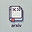 arXiv Dataset Overview

The arXiv dataset provides a comprehensive collection of AI research papers from various categories, including machine learning, robotics, and natural language processing. It covers a wide range of publications spanning multiple decades, offering rich metadata such as titles, abstracts, publication dates, and keywords.

### Why this dataset is important:

- **Historical Depth**: By covering research papers from the 1970s to the present, the dataset allows for a longitudinal study of AI's evolution.
- **Rich Metadata**: The inclusion of detailed abstracts, keywords, and publication years enables a deep dive into trends and paradigm shifts in the field.
- **Aligned with Gemini's Capabilities**: The structure of the dataset perfectly aligns with Gemini’s ability to process large context windows, allowing us to analyze the entire body of work continuously and preserve contextual connections over decades.

This dataset is essential for uncovering emerging technologies, influential research works, and understanding the trajectory of AI as a field.


In [1]:
try:
    import arxiv
    print("arxiv is already installed.")
except ImportError:
    # If arxiv is not installed, install it
    !pip install arxiv

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=934e6d711d02a083866ac295e7e36ef2506d2043873d950b85e622c06322b0aa
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [2]:
# Import all necessary libraries here.
import arxiv
import pandas as pd
import time
import warnings
from IPython.display import display

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

## 📊 Dataset Overview
The dataset used in this analysis contains a comprehensive collection of AI research papers spanning over 50 years. Sourced from arXiv.org and NeurIPS conference proceedings, it includes metadata such as titles, authors, abstracts, publication dates, and key terms. This structured information allows us to analyze the evolution of AI research and track paradigm shifts within the field.

### Why this dataset is valuable:
- **Comprehensive Coverage**: The dataset spans multiple decades, capturing the progression of AI research from its early stages to the present.
- **Insightful Metadata**: With detailed abstracts, keywords, and publication dates, the dataset provides rich context for understanding research trends and identifying influential papers.
- **Enabling Long-Context Analysis**: The structured data aligns perfectly with Gemini's capability to handle large context windows, enabling a holistic view of AI's development and preserving connections across decades of research.

This dataset is essential for identifying patterns, understanding the evolution of terminology, and uncovering the emerging technologies that shape the future of AI.
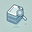

In [4]:
# Query for AI-related papers from the arXiv API
search_query = 'cat:cs.AI OR cat:stat.ML OR cat:cs.LG'

# Initialize an empty list to store papers
papers = []
total_results = 50000  # Total number of results you want to retrieve
batch_size = 100  # The maximum batch size supported by arXiv API
current_count = 0

# Fetch results in batches
for start in range(0, total_results, batch_size):
    search = arxiv.Search(
        query=search_query,
        max_results=batch_size,
        sort_by=arxiv.SortCriterion.SubmittedDate
    )

    try:
        # Fetch results from the search object
        for result in search.results():
            papers.append({
                'title': result.title,
                'authors': [author.name for author in result.authors],
                'abstract': result.summary,
                'published': result.published,
                'categories': result.categories,
                'pdf_url': result.pdf_url
            })
            current_count += 1
            if current_count >= total_results:
                break
        time.sleep(3)  
    except arxiv.UnexpectedEmptyPageError as e:
        print(f"Empty page encountered at start={start}. Skipping this batch.")
        continue 
    except Exception as e:
        print(f"An error occurred: {e}")
        break

# Display the total number of papers retrieved and the first few entries
print(f"Total papers retrieved: {len(papers)}")

Total papers retrieved: 50000


In [5]:
# After fetching the papers, save the metadata to a CSV file for easier use in Kaggle working directory (/kaggle/working)
df = pd.DataFrame(papers)
df.to_csv('/kaggle/working/arxiv_ai_papers.csv', index=False)

In [6]:
# Organize by decades to fit our analysis.
df = pd.read_csv('/kaggle/working/arxiv_ai_papers.csv')

# Convert the published date to a datetime format
df['published'] = pd.to_datetime(df['published'])

# Extract the year and create a decade column
df['year'] = df['published'].dt.year
df['decade'] = (df['year'] // 10) * 10

# Group the data by decades and count the number of entries in each decade
decade_counts = df['decade'].value_counts().sort_index()

# Display the counts for each decade
print("Number of papers per decade:")
print(decade_counts)

# Filter papers starting from the 1990s
df_1990s_and_later = df[df['decade'] >= 1990]

display(df_1990s_and_later.head(10))

Number of papers per decade:
decade
2020    50000
Name: count, dtype: int64


,title,authors,abstract,published,categories,pdf_url,year,decade
0,Reflection-Bench: probing AI intelligence with...,"['Lingyu Li', 'Yixu Wang', 'Haiquan Zhao', 'Sh...",The ability to adapt beliefs or behaviors in r...,2024-10-21 17:59:50+00:00,['cs.AI'],http://arxiv.org/pdf/2410.16270v1,2024,2020
1,xGen-MM-Vid (BLIP-3-Video): You Only Need 32 T...,"['Michael S. Ryoo', 'Honglu Zhou', 'Shrikant K...",We present xGen-MM-Vid (BLIP-3-Video): a multi...,2024-10-21 17:59:11+00:00,"['cs.CV', 'cs.AI', 'cs.CL', 'cs.LG']",http://arxiv.org/pdf/2410.16267v1,2024,2020
2,3DGS-Enhancer: Enhancing Unbounded 3D Gaussian...,"['Xi Liu', 'Chaoyi Zhou', 'Siyu Huang']",Novel-view synthesis aims to generate novel vi...,2024-10-21 17:59:09+00:00,"['cs.CV', 'cs.AI']",http://arxiv.org/pdf/2410.16266v1,2024,2020
3,CompassJudger-1: All-in-one Judge Model Helps ...,"['Maosong Cao', 'Alexander Lam', 'Haodong Duan...",Efficient and accurate evaluation is crucial f...,2024-10-21 17:56:51+00:00,"['cs.CL', 'cs.AI']",http://arxiv.org/pdf/2410.16256v1,2024,2020
4,Revisiting Deep Feature Reconstruction for Log...,"['Sukanya Patra', 'Souhaib Ben Taieb']",Industrial anomaly detection is crucial for qu...,2024-10-21 17:56:47+00:00,"['cs.CV', 'cs.LG']",http://arxiv.org/pdf/2410.16255v1,2024,2020
5,Distribution Learning with Valid Outputs Beyon...,"['Nick Rittler', 'Kamalika Chaudhuri']","Generative models at times produce ""invalid"" o...",2024-10-21 17:56:09+00:00,['cs.LG'],http://arxiv.org/pdf/2410.16253v1,2024,2020
6,Implicit Regularization for Tubal Tensor Facto...,"['Santhosh Karnik', 'Anna Veselovska', 'Mark I...",We provide a rigorous analysis of implicit reg...,2024-10-21 17:52:01+00:00,"['cs.LG', 'math.OC', 'math.ST', 'stat.ML', 'st...",http://arxiv.org/pdf/2410.16247v1,2024,2020
7,MoRE: Multi-Modal Contrastive Pre-training wit...,"['Samrajya Thapa', 'Koushik Howlader', 'Subhan...","In this paper, we introduce a novel Multi-Moda...",2024-10-21 17:42:41+00:00,"['cs.AI', 'cs.CV', 'cs.LG']",http://arxiv.org/pdf/2410.16239v1,2024,2020
8,Sketch2Code: Evaluating Vision-Language Models...,"['Ryan Li', 'Yanzhe Zhang', 'Diyi Yang']",Sketches are a natural and accessible medium f...,2024-10-21 17:39:49+00:00,"['cs.CL', 'cs.AI']",http://arxiv.org/pdf/2410.16232v1,2024,2020
9,A Realistic Threat Model for Large Language Mo...,"['Valentyn Boreiko', 'Alexander Panfilov', 'Va...",A plethora of jailbreaking attacks have been p...,2024-10-21 17:27:01+00:00,['cs.LG'],http://arxiv.org/pdf/2410.16222v1,2024,2020
